# MAGIC04 - MAGIC Gamma Telescope
## Data are MC generated to simulate registration of high energy gamma particles in an atmospheric Cherenkov telescope

### Dataset Information

### Additional Information

The data are MC generated (see below) to simulate registration of high energy gamma particles in a ground-based atmospheric Cherenkov gamma telescope using the imaging technique. Cherenkov gamma telescope observes high energy gamma rays, taking advantage of the radiation emitted by charged particles produced inside the electromagnetic showers initiated by the gammas, and developing in the atmosphere. This Cherenkov radiation (of visible to UV wavelengths) leaks through the atmosphere and gets recorded in the detector, allowing reconstruction of the shower parameters. The available information consists of pulses left by the incoming Cherenkov photons on the photomultiplier tubes, arranged in a plane, the camera. Depending on the energy of the primary gamma, a total of few hundreds to some 10000 Cherenkov photons get collected, in patterns (called the shower image), allowing to discriminate statistically those caused by primary gammas (signal) from the images of hadronic showers initiated by cosmic rays in the upper atmosphere (background).

Typically, the image of a shower after some pre-processing is an elongated cluster. Its long axis is oriented towards the camera center if the shower axis is parallel to the telescope's optical axis, i.e. if the telescope axis is directed towards a point source. A principal component analysis is performed in the camera plane, which results in a correlation axis and defines an ellipse. If the depositions were distributed as a bivariate Gaussian, this would be an equidensity ellipse. The characteristic parameters of this ellipse (often called Hillas parameters) are among the image parameters that can be used for discrimination. The energy depositions are typically asymmetric along the major axis, and this asymmetry can also be used in discrimination. There are, in addition, further discriminating characteristics, like the extent of the cluster in the image plane, or the total sum of depositions.

The data set was generated by a Monte Carlo program, Corsika, described in:

    D. Heck et al., CORSIKA, A Monte Carlo code to simulate extensive air showers,
    Forschungszentrum Karlsruhe FZKA 6019 (1998).

http://rexa.info/paper?id=ac6e674e9af20979b23d3ed4521f1570765e8d68

The program was run with parameters allowing to observe events with energies down to below 50 GeV.

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import pickle
PIK = "" # if pickle != "" (see next cell), models won't be loaded. To load models run next cell.

### Picle - Loading of models

In [161]:
PIK = "./pickles/pickle01.sav"
## Save
#with open(PIK, 'wb') as f:
#    pickle.dump((data,LR1_model,PCA_model,LR2_model,LDA_model,scaler,LR1_std_model,PCA_std_model,LR2_std_model,LDA_std_model), f)
# Load
with open(PIK, 'rb') as f:
    data,LR1_model,PCA_model,LR2_model,LDA_model,scaler,LR1_std_model,PCA_std_model,LR2_std_model,LDA_std_model = pickle.load(f)

## Exploratory Data Analysis

In [70]:
if PIK == "":
    data = pd.read_csv('magic04.data',header=None)

data.columns=['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist','class']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19020 entries, 0 to 19019
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fLength   19020 non-null  float64
 1   fWidth    19020 non-null  float64
 2   fSize     19020 non-null  float64
 3   fConc     19020 non-null  float64
 4   fConc1    19020 non-null  float64
 5   fAsym     19020 non-null  float64
 6   fM3Long   19020 non-null  float64
 7   fM3Trans  19020 non-null  float64
 8   fAlpha    19020 non-null  float64
 9   fDist     19020 non-null  float64
 10  class     19020 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.6+ MB


In [71]:
# Checking there are no missing values
for col in data.columns:
    print(col,pd.unique(data[col]))
pd.DataFrame(data.isnull().sum(),columns=['Missing_values'])

fLength [ 28.7967  31.6036 162.052  ...  75.4455 120.5135 187.1814]
fWidth [ 16.0021  11.7235 136.031  ...  47.5305  76.9018  53.0014]
fSize [2.6449 2.5185 4.0612 ... 3.6872 2.8307 3.2093]
fConc [0.3918 0.5303 0.0374 ... 0.7544 0.5857 0.0944]
fConc1 [0.1982 0.3773 0.0187 ... 0.3591 0.3791 0.3934]
fAsym [  27.7004   26.2722  116.741  ...   -9.3561    5.8043 -167.3125]
fM3Long [  22.011    23.8238  -64.858  ...   41.0562  -93.5224 -168.4558]
fM3Trans [ -8.2027  -9.9574 -45.216  ...  -9.4662 -63.8389  31.4755]
fAlpha [40.092   6.3609 76.96   ... 30.2987 84.6874 52.731 ]
fDist [ 81.8828 205.261  256.788  ... 256.5166 408.3166 272.3174]
class ['g' 'h']


Missing_values
fLength                0
fWidth                 0
fSize                  0
fConc                  0
fConc1                 0
fAsym                  0
fM3Long                0
fM3Trans               0
fAlpha                 0
fDist                  0
class                  0

In [72]:
#%% DATA QUALITY REPORT
def dqr(data):
    # List of database variables
    cols = pd.DataFrame(list(data.columns.values),
                           columns=['Names'],
                           index=list(data.columns.values))
    # List of data types
    dtyp = pd.DataFrame(data.dtypes,columns=['Type'])
    # List of missing data
    # List of present data
    presval = pd.DataFrame(data.count(),columns=['Present_values'])
    # List of skew values
    skew = pd.DataFrame(data.skew(),columns=['Skew_value'])
    # List of kurtosis values
    kurt = pd.DataFrame(data.kurt(),columns=['Kurtosis_value'])
    # List of unique values
    unival = pd.DataFrame(columns=['Unique_values'])
    # List of min values
    minval = pd.DataFrame(columns=['Min_value'])
    # List of max values
    maxval = pd.DataFrame(columns=['Max_value'])
    for col in list(data.columns.values):
        unival.loc[col] = [data[col].nunique()]
        try:
            minval.loc[col] = [data[col].min()]
            maxval.loc[col] = [data[col].max()]
        except:
            pass
    
    # Join the tables and return the result
    return cols.join(dtyp).join(presval).join(unival).join(minval).join(maxval).join(skew).join(kurt)

#%% Obtaining the data quality report
report = dqr(data[['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist']])
report

Names     Type  Present_values  Unique_values  Min_value  \
fLength    fLength  float64           19020          18643     4.2835   
fWidth      fWidth  float64           19020          18200     0.0000   
fSize        fSize  float64           19020           7228     1.9413   
fConc        fConc  float64           19020           6410     0.0131   
fConc1      fConc1  float64           19020           4421     0.0003   
fAsym        fAsym  float64           19020          18704  -457.9161   
fM3Long    fM3Long  float64           19020          18693  -331.7800   
fM3Trans  fM3Trans  float64           19020          18390  -205.8947   
fAlpha      fAlpha  float64           19020          17981     0.0000   
fDist        fDist  float64           19020          18437     1.2826   

          Max_value  Skew_value  Kurtosis_value  
fLength    334.1770    2.013652        4.970441  
fWidth     256.3820    3.371628       16.765407  
fSize        5.3233    0.875507        0.727278  
fConc        0.8930    0.485888       -0.521297  
fConc1       0.6752    0.685695        0.029391  
fAsym      575.2407   -1.046441        8.155330  
fM3Long    238.3210   -1.123078        4.670974  
fM3Trans   179.8510    0.120121        8.580352  
fAlpha      90.0000    0.850890       -0.533704  
fDist      495.5610    0.229587       -0.112577

In [73]:
#sns.pairplot(data);

In [74]:
data2 = data
data2 = data2.replace('g',0).replace('h',1)
data2['class'] = data2['class'].astype('int8')

C:\Users\ingab\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


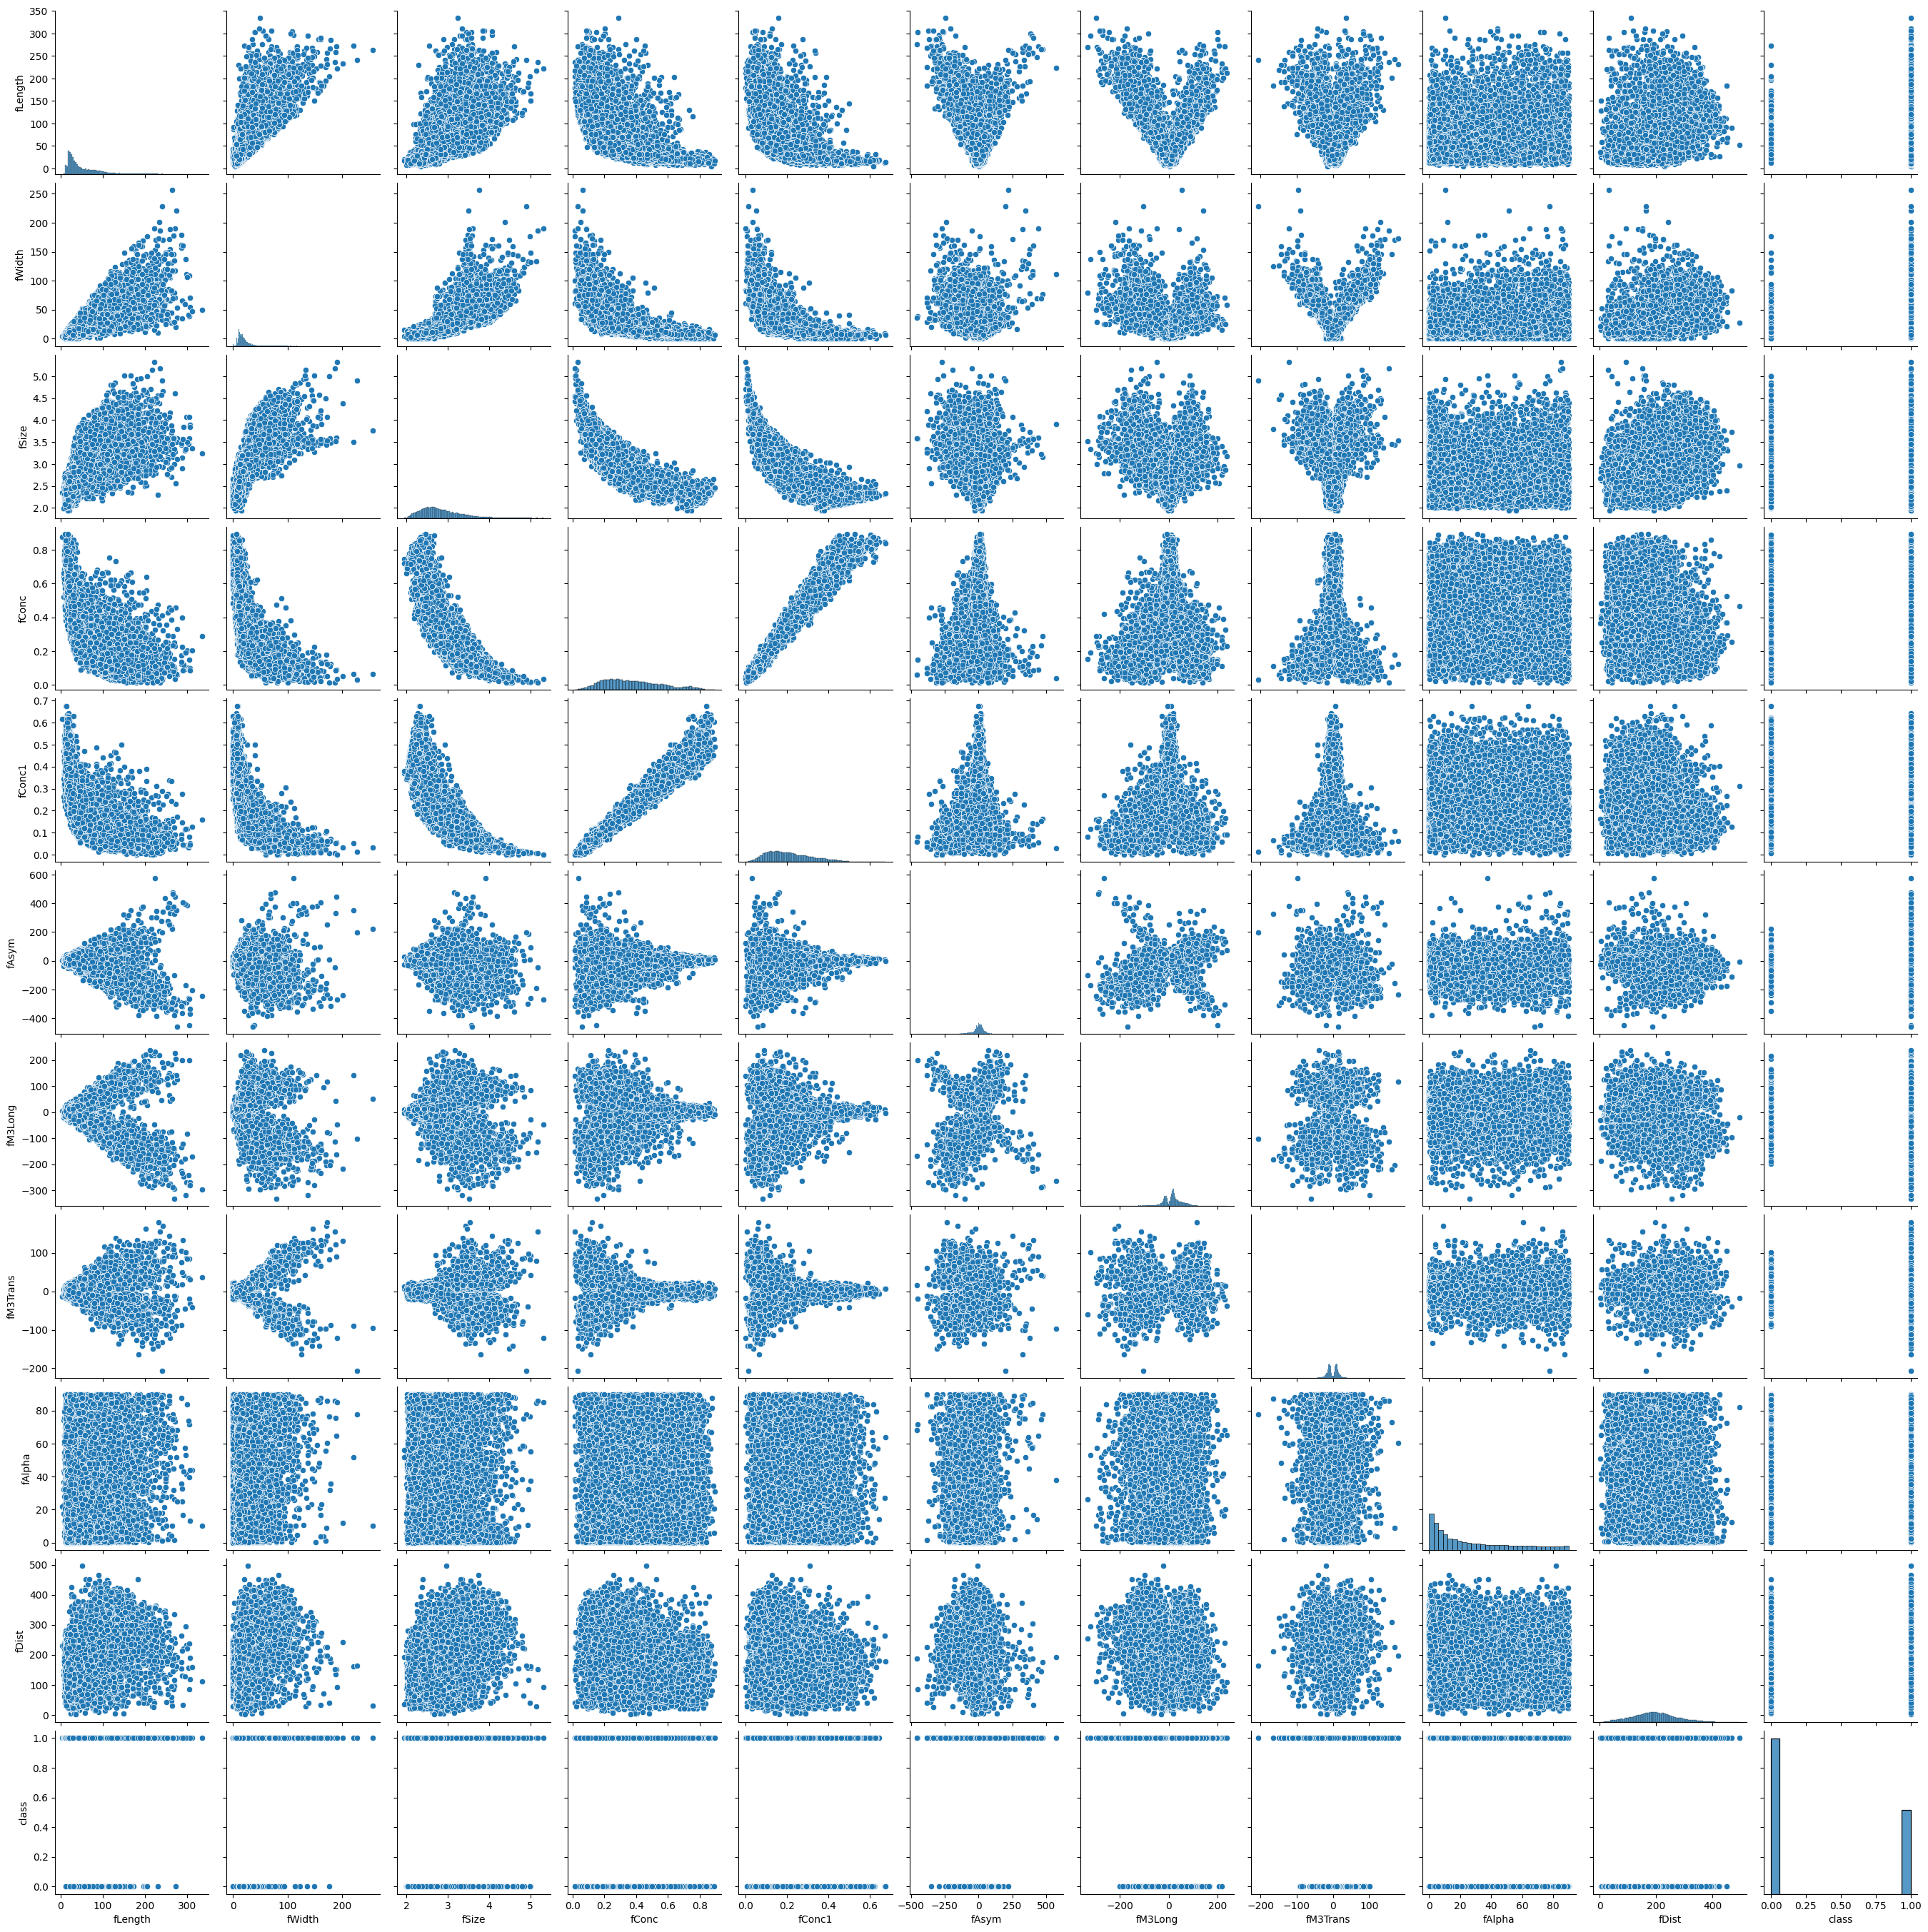

In [8]:
sns.pairplot(data2);

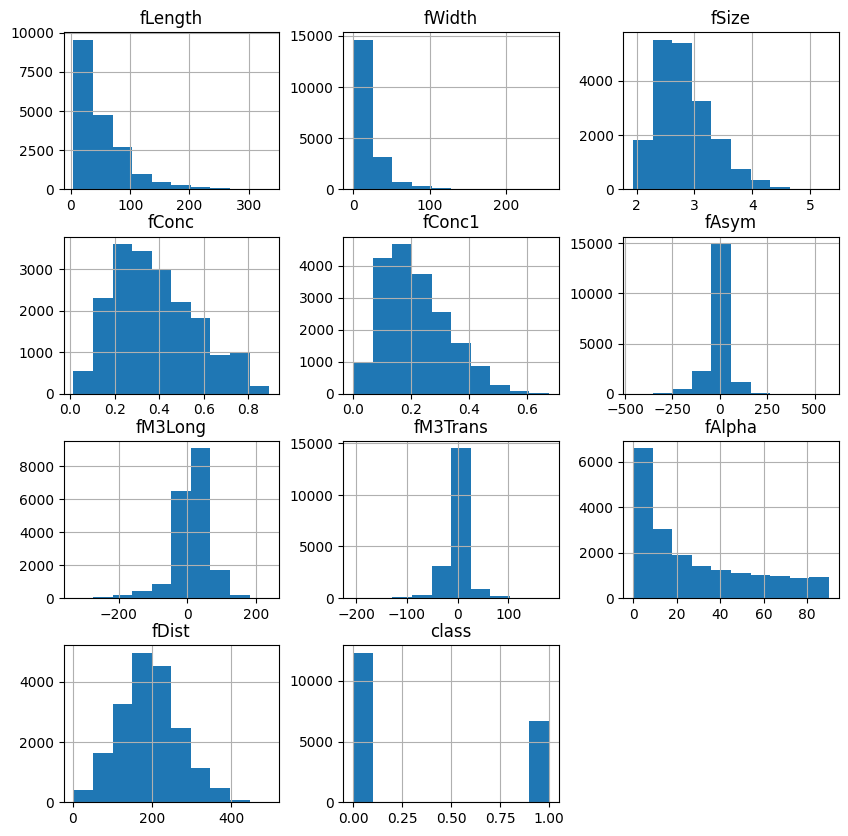

In [75]:
data2.hist(figsize=(10,10));

In [76]:
#%% Obtaining the data quality report
report = dqr(data2)
report

Names     Type  Present_values  Unique_values  Min_value  \
fLength    fLength  float64           19020          18643     4.2835   
fWidth      fWidth  float64           19020          18200     0.0000   
fSize        fSize  float64           19020           7228     1.9413   
fConc        fConc  float64           19020           6410     0.0131   
fConc1      fConc1  float64           19020           4421     0.0003   
fAsym        fAsym  float64           19020          18704  -457.9161   
fM3Long    fM3Long  float64           19020          18693  -331.7800   
fM3Trans  fM3Trans  float64           19020          18390  -205.8947   
fAlpha      fAlpha  float64           19020          17981     0.0000   
fDist        fDist  float64           19020          18437     1.2826   
class        class     int8           19020              2     0.0000   

          Max_value  Skew_value  Kurtosis_value  
fLength    334.1770    2.013652        4.970441  
fWidth     256.3820    3.371628       16.765407  
fSize        5.3233    0.875507        0.727278  
fConc        0.8930    0.485888       -0.521297  
fConc1       0.6752    0.685695        0.029391  
fAsym      575.2407   -1.046441        8.155330  
fM3Long    238.3210   -1.123078        4.670974  
fM3Trans   179.8510    0.120121        8.580352  
fAlpha      90.0000    0.850890       -0.533704  
fDist      495.5610    0.229587       -0.112577  
class        1.0000    0.621522       -1.613880

In [77]:
# Getting proportion of 0 to 1 in output 'class'
data2.groupby(['class']).size()[0]/data2.groupby(['class']).size()[1]

1.8438995215311005

In [78]:
data2.corr()

fLength    fWidth     fSize     fConc    fConc1     fAsym  \
fLength   1.000000  0.770512  0.702454 -0.630999 -0.598145 -0.368556   
fWidth    0.770512  1.000000  0.717517 -0.609779 -0.581141 -0.266961   
fSize     0.702454  0.717517  1.000000 -0.850850 -0.808835 -0.159863   
fConc    -0.630999 -0.609779 -0.850850  1.000000  0.976412  0.112272   
fConc1   -0.598145 -0.581141 -0.808835  0.976412  1.000000  0.100159   
fAsym    -0.368556 -0.266961 -0.159863  0.112272  0.100159  1.000000   
fM3Long  -0.119747 -0.176234  0.095157 -0.121899 -0.118769  0.274045   
fM3Trans  0.013389  0.039744  0.015455 -0.011294 -0.010966  0.002553   
fAlpha   -0.008777  0.066061 -0.186675  0.235272  0.229799 -0.055689   
fDist     0.418466  0.336816  0.437041 -0.328332 -0.304625 -0.206730   
class     0.307572  0.265596  0.117795 -0.024615 -0.004797 -0.173587   

           fM3Long  fM3Trans    fAlpha     fDist     class  
fLength  -0.119747  0.013389 -0.008777  0.418466  0.307572  
fWidth   -0.176234  0.039744  0.066061  0.336816  0.265596  
fSize     0.095157  0.015455 -0.186675  0.437041  0.117795  
fConc    -0.121899 -0.011294  0.235272 -0.328332 -0.024615  
fConc1   -0.118769 -0.010966  0.229799 -0.304625 -0.004797  
fAsym     0.274045  0.002553 -0.055689 -0.206730 -0.173587  
fM3Long   1.000000 -0.017197 -0.186275  0.037025 -0.193409  
fM3Trans -0.017197  1.000000  0.004659  0.011427  0.003837  
fAlpha   -0.186275  0.004659  1.000000 -0.220556  0.460979  
fDist     0.037025  0.011427 -0.220556  1.000000  0.065203  
class    -0.193409  0.003837  0.460979  0.065203  1.000000

In [79]:
data2.cov()

fLength      fWidth      fSize     fConc    fConc1        fAsym  \
fLength   1794.780934  598.863542  14.064229 -4.886995 -2.800380  -924.434103   
fWidth     598.863542  336.577782   6.221102 -2.045137 -1.178226  -289.972346   
fSize       14.064229    6.221102   0.223349 -0.073511 -0.042243    -4.473078   
fConc       -4.886995   -2.045137  -0.073511  0.033421  0.019726     1.215195   
fConc1      -2.800380   -1.178226  -0.042243  0.019726  0.012213     0.655333   
fAsym     -924.434103 -289.972346  -4.473078  1.215195  0.655333  3505.357776   
fM3Long   -258.727155 -164.893734   2.293535 -1.136528 -0.669389   827.482747   
fM3Trans    11.814008   15.186087   0.152121 -0.043003 -0.025239     3.147931   
fAlpha      -9.706818   31.636694  -2.302925  1.122738  0.662907   -86.066350   
fDist     1324.864131  461.786200  15.435467 -4.485661 -2.515795  -914.690722   
class        6.221837    2.326648   0.026582 -0.002149 -0.000253    -4.907381   

              fM3Long    fM3Trans      fAlpha        fDist     class  
fLength   -258.727155   11.814008   -9.706818  1324.864131  6.221837  
fWidth    -164.893734   15.186087   31.636694   461.786200  2.326648  
fSize        2.293535    0.152121   -2.302925    15.435467  0.026582  
fConc       -1.136528   -0.043003    1.122738    -4.485661 -0.002149  
fConc1      -0.669389   -0.025239    0.662907    -2.515795 -0.000253  
fAsym      827.482747    3.147931  -86.066350  -914.690722 -4.907381  
fM3Long   2601.012037  -18.266361 -247.985080   141.115155 -4.709923  
fM3Trans   -18.266361  433.782213    2.533034    17.785198  0.038161  
fAlpha    -247.985080    2.533034  681.399004  -430.253247  5.745768  
fDist      141.115155   17.785198 -430.253247  5584.839983  2.326678  
class       -4.709923    0.038161    5.745768     2.326678  0.227998

## Not standardizing data

In [80]:
X_columns = ['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist']
X = data2[X_columns]
Y = data2['class']
X.head()

fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist  
0  40.0920   81.8828  
1   6.3609  205.2610  
2  76.9600  256.7880  
3  10.4490  116.7370  
4   4.6480  356.4620

### Data splitting in train, cross validation and test subsets

In [81]:
# The train, crosvalidation and tes subsets are created
X_train, X_, Y_train, Y_ = train_test_split(X, Y, test_size=0.3, random_state=0)
X_cv, X_test, Y_cv, Y_test = train_test_split(X_, Y_, test_size=0.5, random_state=0)

### Logistic regression (no reduction of predictor variables)

In [82]:
if PIK == "":
    LR1_model = LogisticRegression(random_state=0)
    LR1_model.fit(X_train, Y_train)
    
LR1_Yhat_train = LR1_model.predict(X_train)
LR1_Yhat_cv = LR1_model.predict(X_cv)
LR1_Yhat_test = LR1_model.predict(X_test)

LR1_accuracy_train_cv_test = [accuracy_score(Y_train, LR1_Yhat_train), accuracy_score(Y_cv, LR1_Yhat_cv),accuracy_score(Y_test, LR1_Yhat_test)]
LR1_precision_train_cv_test = [precision_score(Y_train, LR1_Yhat_train), precision_score(Y_cv, LR1_Yhat_cv),precision_score(Y_test, LR1_Yhat_test)]
LR1_recall_train_cv_test = [recall_score(Y_train, LR1_Yhat_train), recall_score(Y_cv, LR1_Yhat_cv),recall_score(Y_test, LR1_Yhat_test)]
LR1_F1_Score_train_cv_test = [f1_score(Y_train, LR1_Yhat_train), f1_score(Y_cv, LR1_Yhat_cv),f1_score(Y_test, LR1_Yhat_test)]
LR1_ROC_AUC_Score_train_cv_test = [roc_auc_score(Y_train, LR1_Yhat_train), roc_auc_score(Y_cv, LR1_Yhat_cv),roc_auc_score(Y_test, LR1_Yhat_test)]

print('LR1_accuracy_train_cv_test =', LR1_accuracy_train_cv_test)
print('LR1_precision_train_cv_test =', LR1_precision_train_cv_test)
print('LR1_recall_train_cv_test =', LR1_recall_train_cv_test)
print('LR1_F1_Score_train_cv_test =', LR1_F1_Score_train_cv_test)
print('LR1_ROC_AUC_Score_train_cv_test =', LR1_ROC_AUC_Score_train_cv_test)


LR1_accuracy_train_cv_test = [0.788117770767613, 0.7939011566771819, 0.7868909919383106]
LR1_precision_train_cv_test = [0.7549614112458655, 0.7838541666666666, 0.7471116816431322]
LR1_recall_train_cv_test = [0.5863840719332049, 0.587890625, 0.5861027190332326]
LR1_F1_Score_train_cv_test = [0.6600795276539342, 0.671875, 0.6568848758465011]
LR1_ROC_AUC_Score_train_cv_test = [0.7417631339649826, 0.7485653234349372, 0.7400943702693045]


### Logistic Regression with predictors reduced via PCA

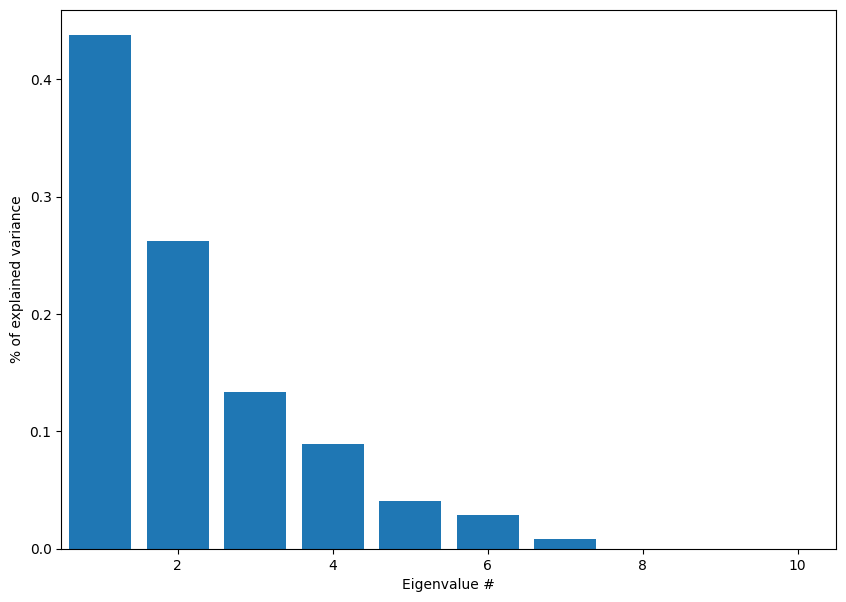

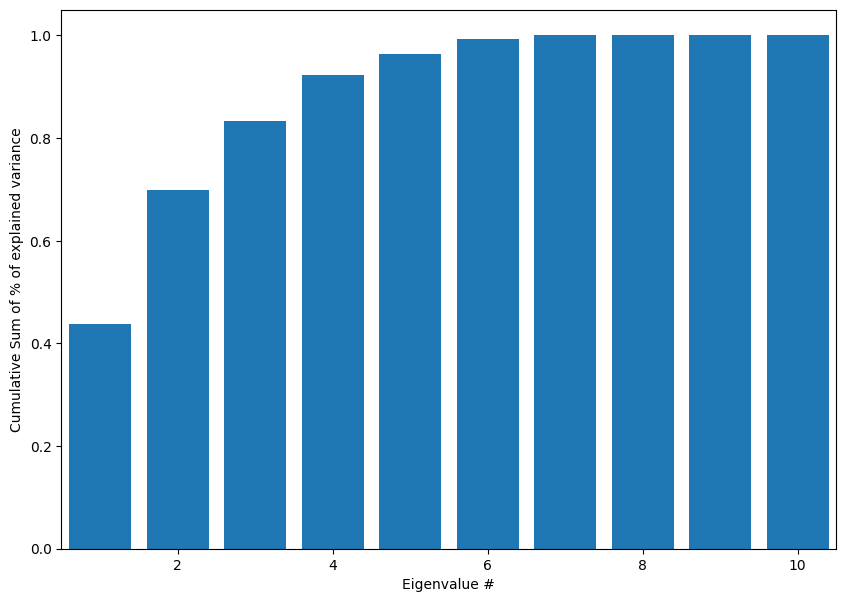

Cumulative sum of explained variance (%): [ 43.72856384  69.9554782   83.34362493  92.29161994  96.32070247
  99.2063338   99.99935259  99.99992594  99.99999742 100.        ]


In [83]:
if PIK == "":
    PCA_model = PCA(random_state=0)
    PCA_model.fit(X_train)

X_train_pca = PCA_model.transform(X_train)
X_cv_pca = PCA_model.transform(X_cv)
X_test_pca = PCA_model.transform(X_test)

PCA_EV = PCA_model.explained_variance_ratio_
PCA_EV
PCA_Evectors = PCA_model.components_
# Plotting the covariance ratio
plt.figure(figsize=(10,7))
plt.bar(np.arange(1,len(PCA_EV)+1),PCA_EV)
plt.xlabel('Eigenvalue #')
plt.ylabel('% of explained variance')
plt.xlim(0.5,len(PCA_EV)+0.5)
plt.show()
# Plotting the cumulative sum of covariance ratio
plt.figure(figsize=(10,7))
plt.bar(np.arange(1,len(PCA_EV)+1),np.cumsum(PCA_EV))
plt.xlabel('Eigenvalue #')
plt.ylabel('Cumulative Sum of % of explained variance')
plt.xlim(0.5,len(PCA_EV)+0.5)
plt.show()
cumsumvar_PCA = np.cumsum(PCA_EV)
print('Cumulative sum of explained variance (%):', 100*cumsumvar_PCA)


In [84]:
# Five eigenvectors can explain up to 96% of variance, while 4 can explain around ~92%
# We will select first 4 vectors
N_eigenvectors_PCA=4
print(N_eigenvectors_PCA,'columns selected with', 100*cumsumvar_PCA[N_eigenvectors_PCA-1],'% of explained variance')

X_train_pca_r = X_train_pca[:,0:N_eigenvectors_PCA]
X_cv_pca_r = X_cv_pca[:,0:N_eigenvectors_PCA]
X_test_pca_r = X_test_pca[:,0:N_eigenvectors_PCA]

if PIK == "":
    LR2_model = LogisticRegression(random_state=0)
    LR2_model.fit(X_train_pca_r, Y_train)

LR2_Yhat_train = LR2_model.predict(X_train_pca_r)
LR2_Yhat_cv = LR2_model.predict(X_cv_pca_r)
LR2_Yhat_test = LR2_model.predict(X_test_pca_r)

LR2_accuracy_train_cv_test = [accuracy_score(Y_train, LR2_Yhat_train), accuracy_score(Y_cv, LR2_Yhat_cv),accuracy_score(Y_test, LR2_Yhat_test)]
LR2_precision_train_cv_test = [precision_score(Y_train, LR2_Yhat_train), precision_score(Y_cv, LR2_Yhat_cv),precision_score(Y_test, LR2_Yhat_test)]
LR2_recall_train_cv_test = [recall_score(Y_train, LR2_Yhat_train), recall_score(Y_cv, LR2_Yhat_cv),recall_score(Y_test, LR2_Yhat_test)]
LR2_F1_Score_train_cv_test = [f1_score(Y_train, LR2_Yhat_train), f1_score(Y_cv, LR2_Yhat_cv),f1_score(Y_test, LR2_Yhat_test)]
LR2_ROC_AUC_Score_train_cv_test = [roc_auc_score(Y_train, LR2_Yhat_train), roc_auc_score(Y_cv, LR2_Yhat_cv),roc_auc_score(Y_test, LR2_Yhat_test)]

print('LR2_accuracy_train_cv_test =', LR2_accuracy_train_cv_test)
print('LR2_precision_train_cv_test =', LR2_precision_train_cv_test)
print('LR2_recall_train_cv_test =', LR2_recall_train_cv_test)
print('LR2_F1_Score_train_cv_test =', LR2_F1_Score_train_cv_test)
print('LR2_ROC_AUC_Score_train_cv_test =', LR2_ROC_AUC_Score_train_cv_test)

4 columns selected with 92.29161994068964 % of explained variance
LR2_accuracy_train_cv_test = [0.7404987231485655, 0.7343147563967753, 0.7521906764808973]
LR2_precision_train_cv_test = [0.8307943416757345, 0.8614130434782609, 0.8454106280193237]
LR2_recall_train_cv_test = [0.3269107257546564, 0.3095703125, 0.35246727089627394]
LR2_F1_Score_train_cv_test = [0.46919649715778156, 0.45545977011494254, 0.4975124378109453]
LR2_ROC_AUC_Score_train_cv_test = [0.6454639247192813, 0.6408431114167579, 0.6590293343728681]


### LDA Classification

In [85]:
if PIK == "":
    LDA_model = LDA(store_covariance=True)
    LDA_model.fit(X_train,Y_train)

print('LDA explained_variance_ratio_ =',LDA_model.explained_variance_ratio_)
print('LDA coef_ =',LDA_model.coef_)

LR3_Yhat_train = LDA_model.predict(X_train)
LR3_Yhat_cv = LDA_model.predict(X_cv)
LR3_Yhat_test = LDA_model.predict(X_test)

LR3_accuracy_train_cv_test = [accuracy_score(Y_train, LR3_Yhat_train), accuracy_score(Y_cv, LR3_Yhat_cv),accuracy_score(Y_test, LR3_Yhat_test)]
LR3_precision_train_cv_test = [precision_score(Y_train, LR3_Yhat_train), precision_score(Y_cv, LR3_Yhat_cv),precision_score(Y_test, LR3_Yhat_test)]
LR3_recall_train_cv_test = [recall_score(Y_train, LR3_Yhat_train), recall_score(Y_cv, LR3_Yhat_cv),recall_score(Y_test, LR3_Yhat_test)]
LR3_F1_Score_train_cv_test = [f1_score(Y_train, LR3_Yhat_train), f1_score(Y_cv, LR3_Yhat_cv),f1_score(Y_test, LR3_Yhat_test)]
LR3_ROC_AUC_Score_train_cv_test = [roc_auc_score(Y_train, LR3_Yhat_train), roc_auc_score(Y_cv, LR3_Yhat_cv),roc_auc_score(Y_test, LR3_Yhat_test)]

print('LR3_accuracy_train_cv_test =', LR3_accuracy_train_cv_test)
print('LR3_precision_train_cv_test =', LR3_precision_train_cv_test)
print('LR3_recall_train_cv_test =', LR3_recall_train_cv_test)
print('LR3_F1_Score_train_cv_test =', LR3_F1_Score_train_cv_test)
print('LR3_ROC_AUC_Score_train_cv_test =', LR3_ROC_AUC_Score_train_cv_test)

LDA explained_variance_ratio_ = [1.]
LDA coef_ = [[ 2.29588934e-02 -3.52570612e-03  7.91091460e-01 -3.53896509e-01
   5.52086053e+00 -7.30905171e-04 -3.55788131e-03 -8.71879543e-04
   5.21986666e-02  1.57527649e-03]]
LR3_accuracy_train_cv_test = [0.782935256121376, 0.7872415001752541, 0.7798808271994392]
LR3_precision_train_cv_test = [0.7626069006192864, 0.7899860917941586, 0.7462887989203779]
LR3_recall_train_cv_test = [0.5536287732819525, 0.5546875, 0.5568982880161127]
LR3_F1_Score_train_cv_test = [0.6415281567849169, 0.6517498565691336, 0.637831603229527]
LR3_ROC_AUC_Score_train_cv_test = [0.7302449084505331, 0.736064362356479, 0.7279115095994542]


### Results

In [86]:
Res_cols = ['LogisticRegression','LogisticRegression_PCA','LDA_classification']
Index = ['Train','Cross_Validation','Test']

accuracy_metrics = np.array([LR1_accuracy_train_cv_test,LR2_accuracy_train_cv_test,LR3_accuracy_train_cv_test])
accuracy_metrics_df = pd.concat([pd.DataFrame(Index,columns=['ACCURACY/Subset']),pd.DataFrame(accuracy_metrics,columns=Res_cols)],axis=1)
accuracy_metrics_df.set_index('ACCURACY/Subset')

LogisticRegression  LogisticRegression_PCA  \
ACCURACY/Subset                                                
Train                       0.788118                0.793901   
Cross_Validation            0.740499                0.734315   
Test                        0.782935                0.787242   

                  LDA_classification  
ACCURACY/Subset                       
Train                       0.786891  
Cross_Validation            0.752191  
Test                        0.779881

In [87]:
precision_metrics = np.array([LR1_precision_train_cv_test,LR2_precision_train_cv_test,LR3_precision_train_cv_test])
precision_metrics_df = pd.concat([pd.DataFrame(Index,columns=['PRECISION/Subset']),pd.DataFrame(precision_metrics,columns=Res_cols)],axis=1)
precision_metrics_df.set_index('PRECISION/Subset')

LogisticRegression  LogisticRegression_PCA  \
PRECISION/Subset                                               
Train                       0.754961                0.783854   
Cross_Validation            0.830794                0.861413   
Test                        0.762607                0.789986   

                  LDA_classification  
PRECISION/Subset                      
Train                       0.747112  
Cross_Validation            0.845411  
Test                        0.746289

In [88]:
recall_metrics = np.array([LR1_recall_train_cv_test,LR2_recall_train_cv_test,LR3_recall_train_cv_test])
recall_metrics_df = pd.concat([pd.DataFrame(Index,columns=['RECALL/Subset']),pd.DataFrame(recall_metrics,columns=Res_cols)],axis=1)
recall_metrics_df.set_index('RECALL/Subset')

LogisticRegression  LogisticRegression_PCA  \
RECALL/Subset                                                  
Train                       0.586384                0.587891   
Cross_Validation            0.326911                0.309570   
Test                        0.553629                0.554688   

                  LDA_classification  
RECALL/Subset                         
Train                       0.586103  
Cross_Validation            0.352467  
Test                        0.556898

In [90]:
F1_Score_metrics = np.array([LR1_F1_Score_train_cv_test,LR2_F1_Score_train_cv_test,LR3_F1_Score_train_cv_test])
F1_Score_metrics_df = pd.concat([pd.DataFrame(Index,columns=['F1_SCORE/Subset']),pd.DataFrame(F1_Score_metrics,columns=Res_cols)],axis=1)
F1_Score_metrics_df.set_index('F1_SCORE/Subset')

LogisticRegression  LogisticRegression_PCA  \
F1_SCORE/Subset                                                
Train                       0.660080                0.671875   
Cross_Validation            0.469196                0.455460   
Test                        0.641528                0.651750   

                  LDA_classification  
F1_SCORE/Subset                       
Train                       0.656885  
Cross_Validation            0.497512  
Test                        0.637832

In [91]:
ROC_AUC_Score_metrics = np.array([LR1_ROC_AUC_Score_train_cv_test,LR2_ROC_AUC_Score_train_cv_test,LR3_ROC_AUC_Score_train_cv_test])
ROC_AUC_Score_metrics_df = pd.concat([pd.DataFrame(Index,columns=['ROC_AUC_SCORE/Subset']),pd.DataFrame(ROC_AUC_Score_metrics,columns=Res_cols)],axis=1)
ROC_AUC_Score_metrics_df.set_index('ROC_AUC_SCORE/Subset')

LogisticRegression  LogisticRegression_PCA  \
ROC_AUC_SCORE/Subset                                               
Train                           0.741763                0.748565   
Cross_Validation                0.645464                0.640843   
Test                            0.730245                0.736064   

                      LDA_classification  
ROC_AUC_SCORE/Subset                      
Train                           0.740094  
Cross_Validation                0.659029  
Test                            0.727912

## Standardizing Data

In [93]:
X_columns = ['fLength','fWidth','fSize','fConc','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist']
if PIK == "":
    scaler=StandardScaler()
    scaler.fit(data2[X_columns])

X_standardized = pd.DataFrame(scaler.transform(data2[X_columns]),columns=X_columns)

Y = data2['class']
X_standardized.head()

fLength    fWidth     fSize     fConc    fConc1     fAsym   fM3Long  \
0 -0.577226 -0.336804 -0.381130  0.062759 -0.148923  0.541042  0.224818   
1 -0.510969 -0.570027 -0.648595  0.820383  1.471776  0.516919  0.260364   
2  2.568278  6.205858  2.615783 -1.875883 -1.773241  2.044992 -1.478536   
3 -0.694768 -0.687259 -1.029478  1.282069  1.606608  0.532771 -0.333515   
4  0.516622  0.476384  0.711157 -0.347506 -0.284660 -0.020200  0.353086   

   fM3Trans    fAlpha     fDist  
0 -0.405842  0.476816 -1.497866  
1 -0.490094 -0.815418  0.153125  
2 -2.183030  1.889224  0.842635  
3 -0.355359 -0.658804 -1.031463  
4  1.036620 -0.881039  2.176427

### Data splitting in train, cross validation and test subsets

In [94]:
# The train, crosvalidation and tes subsets are created
X_std_train, X_std_, Y_train, Y_ = train_test_split(X_standardized, Y, test_size=0.3, random_state=0)
X_std_cv, X_std_test, Y_cv, Y_test = train_test_split(X_std_, Y_, test_size=0.5, random_state=0)

### Logistic regression (no reduction of predictor variables)

In [96]:
if PIK == "":
    LR1_std_model = LogisticRegression(random_state=0)
    LR1_std_model.fit(X_std_train, Y_train)

LR1_std_Yhat_train = LR1_std_model.predict(X_std_train)
LR1_std_Yhat_cv = LR1_std_model.predict(X_std_cv)
LR1_std_Yhat_test = LR1_std_model.predict(X_std_test)

LR1_std_accuracy_train_cv_test = [accuracy_score(Y_train, LR1_std_Yhat_train), accuracy_score(Y_cv, LR1_std_Yhat_cv),accuracy_score(Y_test, LR1_std_Yhat_test)]
LR1_std_precision_train_cv_test = [precision_score(Y_train, LR1_std_Yhat_train), precision_score(Y_cv, LR1_std_Yhat_cv),precision_score(Y_test, LR1_std_Yhat_test)]
LR1_std_recall_train_cv_test = [recall_score(Y_train, LR1_std_Yhat_train), recall_score(Y_cv, LR1_std_Yhat_cv),recall_score(Y_test, LR1_std_Yhat_test)]
LR1_std_F1_Score_train_cv_test = [f1_score(Y_train, LR1_std_Yhat_train), f1_score(Y_cv, LR1_std_Yhat_cv),f1_score(Y_test, LR1_std_Yhat_test)]
LR1_std_ROC_AUC_Score_train_cv_test = [roc_auc_score(Y_train, LR1_std_Yhat_train), roc_auc_score(Y_cv, LR1_std_Yhat_cv),roc_auc_score(Y_test, LR1_std_Yhat_test)]

print('LR1_accuracy_train_cv_test =', LR1_std_accuracy_train_cv_test)
print('LR1_precision_train_cv_test =', LR1_std_precision_train_cv_test)
print('LR1_recall_train_cv_test =', LR1_std_recall_train_cv_test)
print('LR1_std_F1_Score_train_cv_test =', LR1_std_F1_Score_train_cv_test)
print('LR1_std_ROC_AUC_Score_train_cv_test =', LR1_std_ROC_AUC_Score_train_cv_test)

LR1_accuracy_train_cv_test = [0.7906714736367734, 0.7932001402032948, 0.7882930248860848]
LR1_precision_train_cv_test = [0.7602209944751381, 0.7855263157894737, 0.7484035759897829]
LR1_recall_train_cv_test = [0.5891672018839649, 0.5830078125, 0.5901309164149043]
LR1_std_F1_Score_train_cv_test = [0.6638523700398022, 0.6692825112107624, 0.6599099099099099]
LR1_std_ROC_AUC_Score_train_cv_test = [0.7443695548931568, 0.7469440374692455, 0.7421084689601403]


### Logistic Regression with predictors reduced via PCA

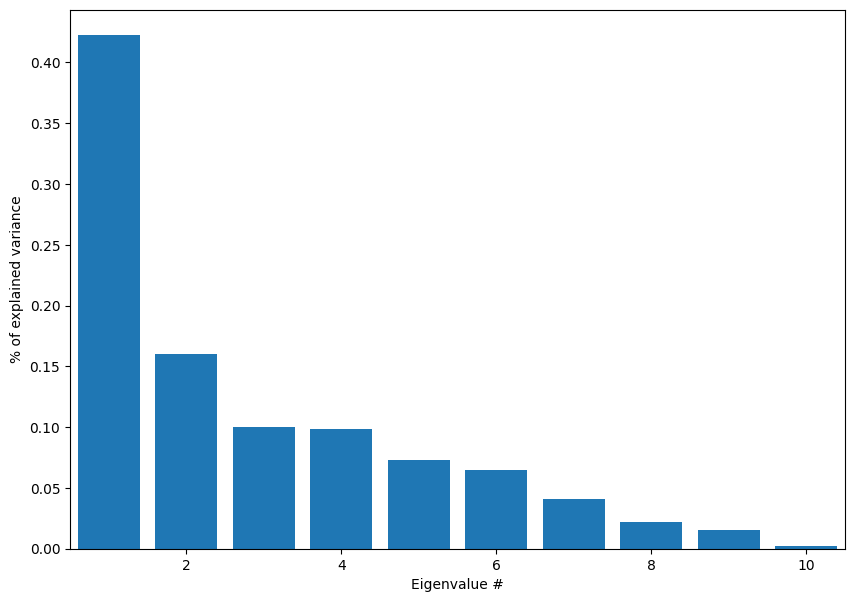

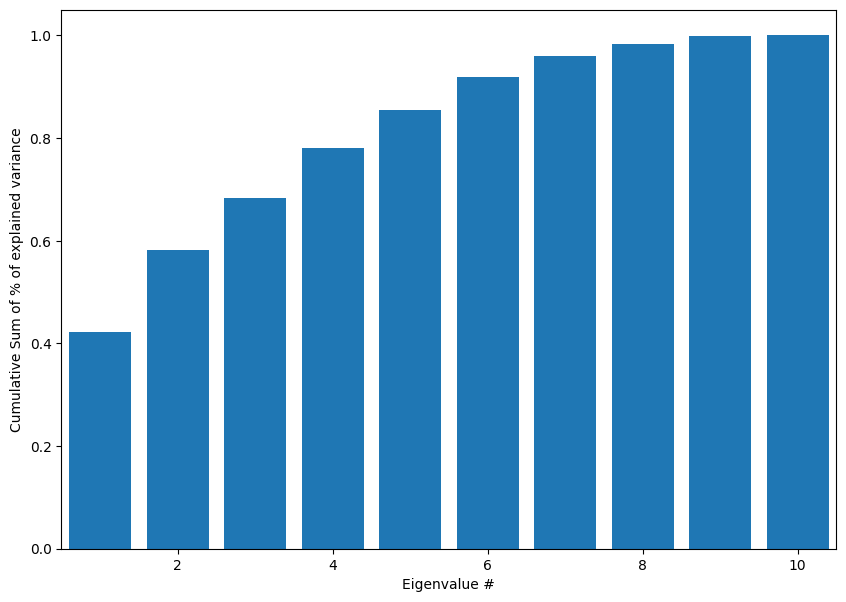

Cumulative sum of explained variance (%): [ 42.22222469  58.26713582  68.29021639  78.14973558  85.46090467
  91.9470872   96.04617194  98.27547243  99.79778938 100.        ]


In [98]:
if PIK == "":
    PCA_std_model = PCA(random_state=0)
    PCA_std_model.fit(X_std_train)

X_std_train_pca = PCA_std_model.transform(X_std_train)
X_std_cv_pca = PCA_std_model.transform(X_std_cv)
X_std_test_pca = PCA_std_model.transform(X_std_test)

PCA_std_EV = PCA_std_model.explained_variance_ratio_
PCA_std_EV
PCA_std_Evectors = PCA_std_model.components_
# Plotting the covariance ratio
plt.figure(figsize=(10,7))
plt.bar(np.arange(1,len(PCA_std_EV)+1),PCA_std_EV)
plt.xlabel('Eigenvalue #')
plt.ylabel('% of explained variance')
plt.xlim(0.5,len(PCA_std_EV)+0.5)
plt.show()
# Plotting the cumulative sum of covariance ratio
plt.figure(figsize=(10,7))
plt.bar(np.arange(1,len(PCA_std_EV)+1),np.cumsum(PCA_std_EV))
plt.xlabel('Eigenvalue #')
plt.ylabel('Cumulative Sum of % of explained variance')
plt.xlim(0.5,len(PCA_std_EV)+0.5)
plt.show()
cumsumvar_PCA_std = np.cumsum(PCA_std_EV)
print('Cumulative sum of explained variance (%):', 100*cumsumvar_PCA_std)

In [99]:
# Seven eigenvectors can explain up to 96% of variance, while 6 can explain around ~92%
# We will select first 6 vectors
N_eigenvectors_PCA_std=6
print(N_eigenvectors_PCA_std,'columns selected with', 100*cumsumvar_PCA_std[N_eigenvectors_PCA_std-1],'% of explained variance')

X_std_train_pca_r = X_std_train_pca[:,0:N_eigenvectors_PCA_std]
X_std_cv_pca_r = X_std_cv_pca[:,0:N_eigenvectors_PCA_std]
X_std_test_pca_r = X_std_test_pca[:,0:N_eigenvectors_PCA_std]

if PIK == "":
    LR2_std_model = LogisticRegression(random_state=0)
    LR2_std_model.fit(X_std_train_pca_r, Y_train)

LR2_std_Yhat_train = LR2_std_model.predict(X_std_train_pca_r)
LR2_std_Yhat_cv = LR2_std_model.predict(X_std_cv_pca_r)
LR2_std_Yhat_test = LR2_std_model.predict(X_std_test_pca_r)

LR2_std_accuracy_train_cv_test = [accuracy_score(Y_train, LR2_std_Yhat_train), accuracy_score(Y_cv, LR2_std_Yhat_cv),accuracy_score(Y_test, LR2_std_Yhat_test)]
LR2_std_precision_train_cv_test = [precision_score(Y_train, LR2_std_Yhat_train), precision_score(Y_cv, LR2_std_Yhat_cv),precision_score(Y_test, LR2_std_Yhat_test)]
LR2_std_recall_train_cv_test = [recall_score(Y_train, LR2_std_Yhat_train), recall_score(Y_cv, LR2_std_Yhat_cv),recall_score(Y_test, LR2_std_Yhat_test)]
LR2_std_F1_Score_train_cv_test = [f1_score(Y_train, LR2_std_Yhat_train), f1_score(Y_cv, LR2_std_Yhat_cv),f1_score(Y_test, LR2_std_Yhat_test)]
LR2_std_ROC_AUC_Score_train_cv_test = [roc_auc_score(Y_train, LR2_std_Yhat_train), roc_auc_score(Y_cv, LR2_std_Yhat_cv),roc_auc_score(Y_test, LR2_std_Yhat_test)]

print('LR2_std_accuracy_train_cv_test =', LR2_std_accuracy_train_cv_test)
print('LR2_std_precision_train_cv_test =', LR2_std_precision_train_cv_test)
print('LR2_std_recall_train_cv_test =', LR2_std_recall_train_cv_test)
print('LR2_std_F1_Score_train_cv_test =', LR2_std_F1_Score_train_cv_test)
print('LR2_std_ROC_AUC_Score_train_cv_test =', LR2_std_ROC_AUC_Score_train_cv_test)

6 columns selected with 91.94708720176638 % of explained variance
LR2_std_accuracy_train_cv_test = [0.7836863452005408, 0.7882930248860848, 0.7809323519102699]
LR2_std_precision_train_cv_test = [0.7500698129014242, 0.7741514360313316, 0.735897435897436]
LR2_std_recall_train_cv_test = [0.5750374652108756, 0.5791015625, 0.5780463242698892]
LR2_std_F1_Score_train_cv_test = [0.6509936984973339, 0.6625698324022347, 0.6474901297236323]
LR2_std_ROC_AUC_Score_train_cv_test = [0.7357427289030197, 0.7422571781882177, 0.7336468180489232]


### LDA Classification

In [100]:
if PIK == "":
    LDA_std_model = LDA(store_covariance=True)
    LDA_std_model.fit(X_train,Y_train)

print('LDA_std explained_variance_ratio_ =',LDA_std_model.explained_variance_ratio_)
print('LDA_std coef_ =',LDA_std_model.coef_)

LR3_std_Yhat_train = LDA_std_model.predict(X_train)
LR3_std_Yhat_cv = LDA_std_model.predict(X_cv)
LR3_std_Yhat_test = LDA_std_model.predict(X_test)

LR3_std_accuracy_train_cv_test = [accuracy_score(Y_train, LR3_std_Yhat_train), accuracy_score(Y_cv, LR3_std_Yhat_cv),accuracy_score(Y_test, LR3_std_Yhat_test)]
LR3_std_precision_train_cv_test = [precision_score(Y_train, LR3_std_Yhat_train), precision_score(Y_cv, LR3_std_Yhat_cv),precision_score(Y_test, LR3_std_Yhat_test)]
LR3_std_recall_train_cv_test = [recall_score(Y_train, LR3_std_Yhat_train), recall_score(Y_cv, LR3_std_Yhat_cv),recall_score(Y_test, LR3_std_Yhat_test)]
LR3_std_F1_Score_train_cv_test = [f1_score(Y_train, LR3_std_Yhat_train), f1_score(Y_cv, LR3_std_Yhat_cv),f1_score(Y_test, LR3_std_Yhat_test)]
LR3_std_ROC_AUC_Score_train_cv_test = [roc_auc_score(Y_train, LR3_std_Yhat_train), roc_auc_score(Y_cv, LR3_std_Yhat_cv),roc_auc_score(Y_test, LR3_std_Yhat_test)]

print('LR3_std_accuracy_train_cv_test =', LR3_std_accuracy_train_cv_test)
print('LR3_std_precision_train_cv_test =', LR3_std_precision_train_cv_test)
print('LR3_std_recall_train_cv_test =', LR3_std_recall_train_cv_test)
print('LR3_std_F1_Score_train_cv_test =', LR3_std_F1_Score_train_cv_test)
print('LR3_std_ROC_AUC_Score_train_cv_test =', LR3_std_ROC_AUC_Score_train_cv_test)

LDA_std explained_variance_ratio_ = [1.]
LDA_std coef_ = [[ 2.29588934e-02 -3.52570612e-03  7.91091460e-01 -3.53896509e-01
   5.52086053e+00 -7.30905171e-04 -3.55788131e-03 -8.71879543e-04
   5.21986666e-02  1.57527649e-03]]
LR3_std_accuracy_train_cv_test = [0.782935256121376, 0.7872415001752541, 0.7798808271994392]
LR3_std_precision_train_cv_test = [0.7626069006192864, 0.7899860917941586, 0.7462887989203779]
LR3_std_recall_train_cv_test = [0.5536287732819525, 0.5546875, 0.5568982880161127]
LR3_std_F1_Score_train_cv_test = [0.6415281567849169, 0.6517498565691336, 0.637831603229527]
LR3_std_ROC_AUC_Score_train_cv_test = [0.7302449084505331, 0.736064362356479, 0.7279115095994542]


### Results

In [101]:
Res_cols = ['LogisticRegression','LogisticRegression_PCA','LDA_classification']
Index = ['Train','Cross_Validation','Test']

accuracy_metrics_std = np.array([LR1_std_accuracy_train_cv_test,LR2_std_accuracy_train_cv_test,LR3_std_accuracy_train_cv_test])
accuracy_metrics_std_df = pd.concat([pd.DataFrame(Index,columns=['ACCURACY/Subset_STD']),pd.DataFrame(accuracy_metrics_std,columns=Res_cols)],axis=1)
accuracy_metrics_std_df.set_index('ACCURACY/Subset_STD')

LogisticRegression  LogisticRegression_PCA  \
ACCURACY/Subset_STD                                               
Train                          0.790671                0.793200   
Cross_Validation               0.783686                0.788293   
Test                           0.782935                0.787242   

                     LDA_classification  
ACCURACY/Subset_STD                      
Train                          0.788293  
Cross_Validation               0.780932  
Test                           0.779881

In [102]:
precision_metrics_std = np.array([LR1_std_precision_train_cv_test,LR2_std_precision_train_cv_test,LR3_std_precision_train_cv_test])
precision_metrics_std_df = pd.concat([pd.DataFrame(Index,columns=['PRECISION/Subset_STD']),pd.DataFrame(precision_metrics_std,columns=Res_cols)],axis=1)
precision_metrics_std_df.set_index('PRECISION/Subset_STD')

LogisticRegression  LogisticRegression_PCA  \
PRECISION/Subset_STD                                               
Train                           0.760221                0.785526   
Cross_Validation                0.750070                0.774151   
Test                            0.762607                0.789986   

                      LDA_classification  
PRECISION/Subset_STD                      
Train                           0.748404  
Cross_Validation                0.735897  
Test                            0.746289

In [103]:
recall_metrics_std = np.array([LR1_std_recall_train_cv_test,LR2_std_recall_train_cv_test,LR3_std_recall_train_cv_test])
recall_metrics_std_df = pd.concat([pd.DataFrame(Index,columns=['RECALL/Subset_STD']),pd.DataFrame(recall_metrics_std,columns=Res_cols)],axis=1)
recall_metrics_std_df.set_index('RECALL/Subset_STD')

LogisticRegression  LogisticRegression_PCA  \
RECALL/Subset_STD                                               
Train                        0.589167                0.583008   
Cross_Validation             0.575037                0.579102   
Test                         0.553629                0.554688   

                   LDA_classification  
RECALL/Subset_STD                      
Train                        0.590131  
Cross_Validation             0.578046  
Test                         0.556898

In [104]:
F1_Score_metrics_std = np.array([LR1_std_F1_Score_train_cv_test,LR2_std_F1_Score_train_cv_test,LR3_std_F1_Score_train_cv_test])
F1_Score_metrics_std_df = pd.concat([pd.DataFrame(Index,columns=['F1_SCORE/Subset']),pd.DataFrame(F1_Score_metrics_std,columns=Res_cols)],axis=1)
F1_Score_metrics_std_df.set_index('F1_SCORE/Subset')

LogisticRegression  LogisticRegression_PCA  \
F1_SCORE/Subset                                                
Train                       0.663852                0.669283   
Cross_Validation            0.650994                0.662570   
Test                        0.641528                0.651750   

                  LDA_classification  
F1_SCORE/Subset                       
Train                       0.659910  
Cross_Validation            0.647490  
Test                        0.637832

In [105]:
ROC_AUC_Score_metrics_std = np.array([LR1_std_ROC_AUC_Score_train_cv_test,LR2_std_ROC_AUC_Score_train_cv_test,LR3_std_ROC_AUC_Score_train_cv_test])
ROC_AUC_Score_metrics_std_df = pd.concat([pd.DataFrame(Index,columns=['ROC_AUC_SCORE/Subset']),pd.DataFrame(ROC_AUC_Score_metrics_std,columns=Res_cols)],axis=1)
ROC_AUC_Score_metrics_std_df.set_index('ROC_AUC_SCORE/Subset')

LogisticRegression  LogisticRegression_PCA  \
ROC_AUC_SCORE/Subset                                               
Train                           0.744370                0.746944   
Cross_Validation                0.735743                0.742257   
Test                            0.730245                0.736064   

                      LDA_classification  
ROC_AUC_SCORE/Subset                      
Train                           0.742108  
Cross_Validation                0.733647  
Test                            0.727912

### Pickle - Saving of models

In [30]:
PIK = "./pickles/pickle01.sav"
# Save
with open(PIK, 'wb') as f:
    pickle.dump((data,LR1_model,PCA_model,LR2_model,LDA_model,scaler,LR1_std_model,PCA_std_model,LR2_std_model,LDA_std_model), f)
## Load
#with open('data.dat', 'rb') as f:
#    data,LR1_model,PCA_model,LR2_model,LDA_model,scaler,LR1_std_model,PCA_std_model,LR2_std_model,LDA_std_model = pickle.load(f)

### Cross validation similar to SVM, with 10 splits

In [ ]:
LR1_model_cv = LogisticRegression(random_state=0)

# Index generator for cross validation
cv = (
    train_test_split(np.arange(Y_train.shape[0]) , test_size=0.3, random_state=i, stratify=Y_train)
    for i in [0, 50503, 8254, 12345, 316, 8902, 7822, 8228, 9574, 336]
)

cv_results = cross_validate(
    LR1_model,
    X_train,
    Y_train.values.ravel(),
    cv=cv,
    scoring=['accuracy', 'precision', 'recall'],
    return_train_score=True,
    # return_estimator=True,
)

## Reducing data with correlation criteria (heuristic method)

In [35]:
# Function definition
def discard_correlated_variables(data, threshold=0.7):
    """
    Discard correlated variables using a heuristic approach.

    Parameters:
    - data (numpy.ndarray): The input data where rows represent samples and columns represent variables.
    - threshold (float): The correlation threshold to consider when discarding variables.

    Returns:
    - selected_features (list): A list of indices of the selected features.
    """
    
    d={}
    for i in list(range(data.shape[1])):
        d[i]= data.columns[i]
    
    
    
    # Step 1: Calculate the correlation matrix
    correlation_matrix = np.corrcoef(data, rowvar=False)
    
    # Initialize a list to keep track of the selected features
    selected_features = list(range(data.shape[1]))
    
    while True:
        # Step 2: Find the pair of variables with the highest correlation
        max_corr = 0
        pair_to_remove = None
        
        for i in range(len(selected_features)):
            for j in range(i + 1, len(selected_features)):
                feature_i = selected_features[i]
                feature_j = selected_features[j]
                correlation = abs(correlation_matrix[feature_i][feature_j])
                
                if correlation > max_corr:
                    max_corr = correlation
                    pair_to_remove = (feature_i, feature_j)
        if max_corr < threshold:
            break
        
        # Check if a pair was found
        if pair_to_remove is None:
            break
        
        # Step 3: Calculate the average correlation of each variable against all other variables
        avg_corr_i = np.mean([abs(correlation_matrix[pair_to_remove[0]][f]) for f in selected_features if f != pair_to_remove[0] and f != pair_to_remove[1]])
        avg_corr_j = np.mean([abs(correlation_matrix[pair_to_remove[1]][f]) for f in selected_features if f != pair_to_remove[1] and f != pair_to_remove[0]])

        
        # Step 4: Remove the variable with the least average correlation
        if avg_corr_i >= avg_corr_j:
            selected_features.remove(pair_to_remove[0])
        else:
            selected_features.remove(pair_to_remove[1])

    l=[]

    for i in selected_features:
        l.append(d[i])
    return data[l]

In [40]:
Xred=data.iloc[:,:-1].copy()
Xred= discard_correlated_variables(Xred, threshold=0.7)
df = pd.concat([Xred,data2['class']],axis=1)
df

fWidth  fConc1     fAsym   fM3Long  fM3Trans   fAlpha     fDist  \
0       16.0021  0.1982   27.7004   22.0110   -8.2027  40.0920   81.8828   
1       11.7235  0.3773   26.2722   23.8238   -9.9574   6.3609  205.2610   
2      136.0310  0.0187  116.7410  -64.8580  -45.2160  76.9600  256.7880   
3        9.5728  0.3922   27.2107   -6.4633   -7.1513  10.4490  116.7370   
4       30.9205  0.1832   -5.5277   28.5525   21.8393   4.6480  356.4620   
...         ...     ...       ...       ...       ...      ...       ...   
19015   10.9170  0.3934   15.2618   11.5245    2.8766   2.4229  106.8258   
19016    6.7020  0.2784   37.0816   13.1853   -2.9632  86.7975  247.4560   
19017   47.5305  0.0549   -9.3561   41.0562   -9.4662  30.2987  256.5166   
19018   76.9018  0.0683    5.8043  -93.5224  -63.8389  84.6874  408.3166   
19019   53.0014  0.1539 -167.3125 -168.4558   31.4755  52.7310  272.3174   

       class  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
19015      1  
19016      1  
19017      1  
19018      1  
19019      1  

[19020 rows x 8 columns]

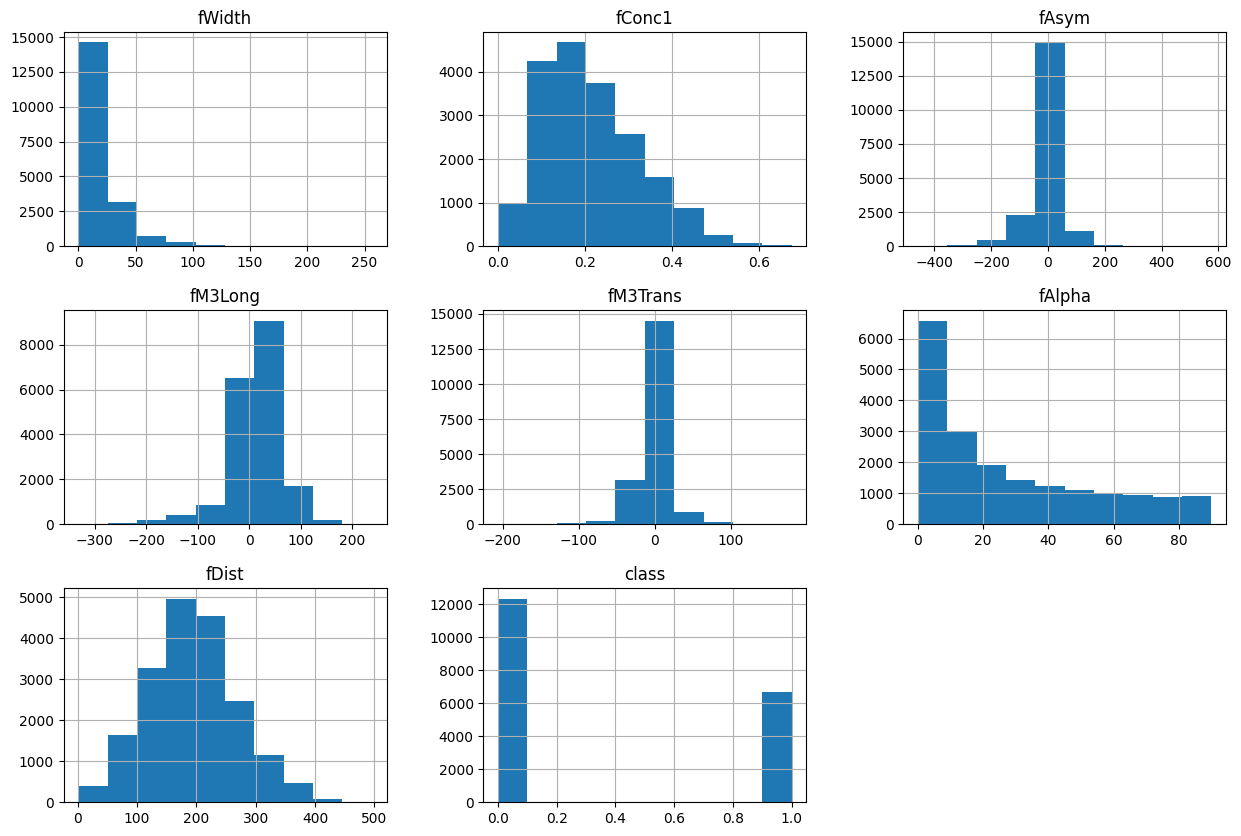

In [43]:
df.hist(figsize=(15,10));

In [45]:
report_red = dqr(df)
report_red

Names     Type  Present_values  Unique_values  Min_value  \
fWidth      fWidth  float64           19020          18200     0.0000   
fConc1      fConc1  float64           19020           4421     0.0003   
fAsym        fAsym  float64           19020          18704  -457.9161   
fM3Long    fM3Long  float64           19020          18693  -331.7800   
fM3Trans  fM3Trans  float64           19020          18390  -205.8947   
fAlpha      fAlpha  float64           19020          17981     0.0000   
fDist        fDist  float64           19020          18437     1.2826   
class        class     int8           19020              2     0.0000   

          Max_value  Skew_value  Kurtosis_value  
fWidth     256.3820    3.371628       16.765407  
fConc1       0.6752    0.685695        0.029391  
fAsym      575.2407   -1.046441        8.155330  
fM3Long    238.3210   -1.123078        4.670974  
fM3Trans   179.8510    0.120121        8.580352  
fAlpha      90.0000    0.850890       -0.533704  
fDist      495.5610    0.229587       -0.112577  
class        1.0000    0.621522       -1.613880

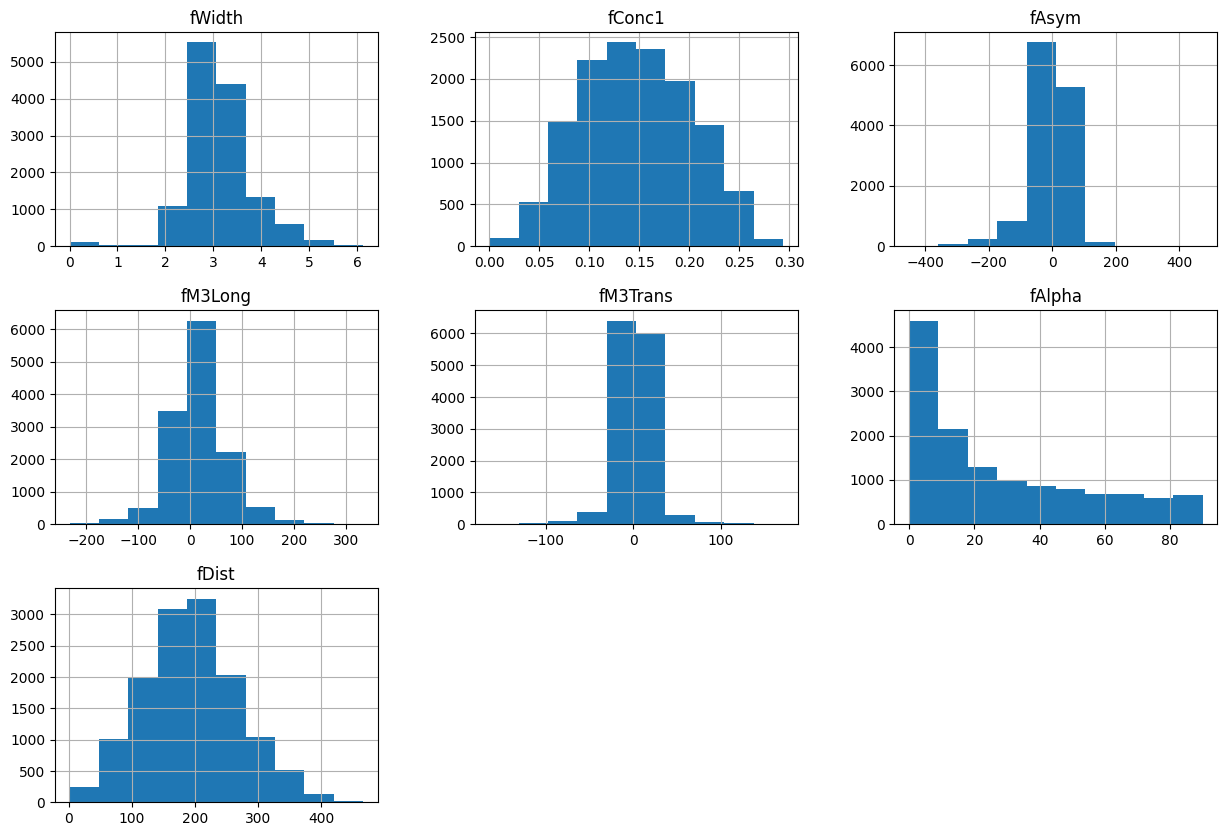

In [55]:
transformer=PowerTransformer(standardize=False)
# The train, crosvalidation and tes subsets are created
X_train, X_, Y_train, Y_ = train_test_split(df.iloc[:,:-1], df['class'], test_size=0.3, random_state=0)
X_cv, X_test, Y_cv, Y_test = train_test_split(X_, Y_, test_size=0.5, random_state=0)

X_train_transformed = X_train.copy()
X_cv_transformed = X_cv.copy()
X_test_transformed = X_test.copy()

X_train_transformed[['fWidth', 'fConc1', 'fM3Long']] = transformer.fit_transform(X_train_transformed[['fWidth', 'fConc1', 'fM3Long']])
X_cv_transformed[['fWidth', 'fConc1', 'fM3Long']] = transformer.transform(X_cv_transformed[['fWidth', 'fConc1', 'fM3Long']])
X_test_transformed[['fWidth', 'fConc1', 'fM3Long']] = transformer.transform(X_test_transformed[['fWidth', 'fConc1', 'fM3Long']])

X_train_transformed.hist(figsize=(15,10));


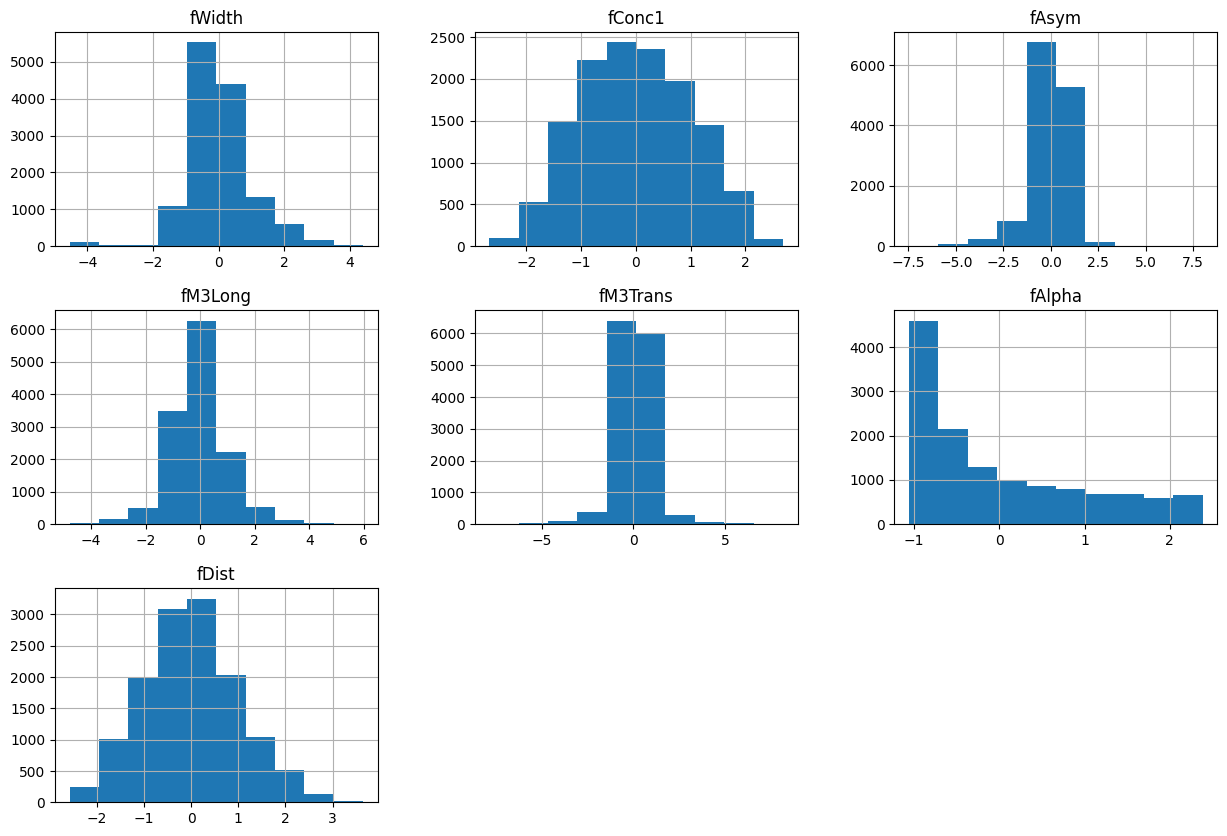

In [56]:
scaler_red = StandardScaler()
X_train_transformed = pd.DataFrame(scaler_red.fit_transform(X_train_transformed),columns=['fWidth','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist'])
X_cv_transformed = pd.DataFrame(scaler_red.transform(X_cv_transformed),columns=['fWidth','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist'])
X_test_transformed = pd.DataFrame(scaler_red.transform(X_test_transformed),columns=['fWidth','fConc1','fAsym','fM3Long','fM3Trans','fAlpha','fDist'])
X_train_transformed.hist(figsize=(15,10));

In [61]:
model1 = LogisticRegression(random_state=0)
model1.fit(X_train_transformed,Y_train)
Yhat1_train = model1.predict(X_train_transformed)
Yhat1_cv = model1.predict(X_cv_transformed)
Yhat1_test = model1.predict(X_test_transformed)

In [140]:
metrics_data_train = {
    'Accuracy': accuracy_score(Y_train,Yhat1_train),
    'Recall': recall_score(Y_train, Yhat1_train),
    'Precision': precision_score(Y_train, Yhat1_train),
    'F1_Score': f1_score(Y_train, Yhat1_train),
    'Roc_Auc_Score': roc_auc_score(Y_train, Yhat1_train),
}

metrics_data_cv = {
    'Accuracy': accuracy_score(Y_cv,Yhat1_cv),
    'Recall': recall_score(Y_cv, Yhat1_cv),
    'Precision': precision_score(Y_cv, Yhat1_cv),
    'F1_Score': f1_score(Y_cv, Yhat1_cv),
    'Roc_Auc_Score': roc_auc_score(Y_cv, Yhat1_cv),
}

metrics_data_test = {
    'Accuracy': accuracy_score(Y_test,Yhat1_test),
    'Recall': recall_score(Y_test, Yhat1_test),
    'Precision': precision_score(Y_test, Yhat1_test),
    'F1_Score': f1_score(Y_test, Yhat1_test),
    'Roc_Auc_Score': roc_auc_score(Y_test, Yhat1_test),
}

print(metrics_data_train,metrics_data_cv,metrics_data_test)

{'Accuracy': 0.770241850683491, 'Recall': 0.5439948619139371, 'Precision': 0.7322766570605187, 'F1_Score': 0.6242476354256233, 'Roc_Auc_Score': 0.7182545176166932} {'Accuracy': 0.768664563617245, 'Recall': 0.5400390625, 'Precision': 0.7452830188679245, 'F1_Score': 0.6262740656851642, 'Roc_Auc_Score': 0.7183519533385729} {'Accuracy': 0.7630564318261479, 'Recall': 0.526686807653575, 'Precision': 0.7174211248285323, 'F1_Score': 0.6074332171893149, 'Roc_Auc_Score': 0.7079670597407659}


In [143]:
Res_cols = ['Accuracy','Recall','Precision','F1_Score','Roc_Auc_Score']
Index = ['Train','Cross_Validation','Test']

metrics_ = pd.DataFrame([metrics_data_train,metrics_data_cv,metrics_data_test])
metrics_ = metrics_.T
metrics_.columns=[Index]

metrics_


Train Cross_Validation      Test
Accuracy       0.770242         0.768665  0.763056
Recall         0.543995         0.540039  0.526687
Precision      0.732277         0.745283  0.717421
F1_Score       0.624248         0.626274  0.607433
Roc_Auc_Score  0.718255         0.718352  0.707967

#### SMOTE resampling

In [146]:
# Original proportion
Y_train[Y_train==1].count()/Y_train.count()

0.3508337088778729

In [148]:
# Creating SMOTE instance
smote = SMOTE(random_state=0)  # Here can be adjusted the desired proportion

# Applying SMOTE to data
X_resampled, Y_resampled = smote.fit_resample(X_train_transformed, Y_train)

In [149]:
# New proportion
Y_resampled[Y_resampled==1].count()/Y_resampled.count()

0.5

In [152]:
model2 = LogisticRegression(random_state=0)
model2.fit(X_resampled,Y_resampled)
Yhat2_train = model2.predict(X_resampled)
Yhat2_cv = model2.predict(X_cv_transformed)
Yhat2_test = model2.predict(X_test_transformed)

In [154]:
metrics_data_train_2 = {
    'Accuracy': accuracy_score(Y_resampled,Yhat2_train),
    'Recall': recall_score(Y_resampled, Yhat2_train),
    'Precision': precision_score(Y_resampled, Yhat2_train),
    'F1 Score': f1_score(Y_resampled, Yhat2_train),
    'Roc_Auc Score': roc_auc_score(Y_resampled, Yhat2_train),
}
metrics_data_cv_2 = {
    'Accuracy': accuracy_score(Y_cv,Yhat2_cv),
    'Recall': recall_score(Y_cv, Yhat2_cv),
    'Precision': precision_score(Y_cv, Yhat2_cv),
    'F1 Score': f1_score(Y_cv, Yhat2_cv),
    'Roc_Auc Score': roc_auc_score(Y_cv, Yhat2_cv),
}
metrics_data_test_2 = {
    'Accuracy': accuracy_score(Y_test,Yhat2_test),
    'Recall': recall_score(Y_test, Yhat2_test),
    'Precision': precision_score(Y_test, Yhat2_test),
    'F1 Score': f1_score(Y_test, Yhat2_test),
    'Roc_Auc Score': roc_auc_score(Y_test, Yhat2_test),
}
print(metrics_data_train_2,metrics_data_cv_2,metrics_data_test_2)

{'Accuracy': 0.7558139534883721, 'Recall': 0.7010297350457018, 'Precision': 0.7872920997920998, 'F1 Score': 0.7416610563681989, 'Roc_Auc Score': 0.7558139534883721} {'Accuracy': 0.7697160883280757, 'Recall': 0.6904296875, 'Precision': 0.6752626552053486, 'F1 Score': 0.6827619507484306, 'Roc_Auc Score': 0.7522678781950519} {'Accuracy': 0.7756747283561164, 'Recall': 0.7049345417925479, 'Precision': 0.6685768863419294, 'F1 Score': 0.6862745098039216, 'Roc_Auc Score': 0.7591877010038008}


In [155]:
Res_cols = ['Accuracy','Recall','Precision','F1_Score','Roc_Auc_Score']
Index = ['Train','Cross_Validation','Test']

metrics_2 = pd.DataFrame([metrics_data_train_2,metrics_data_cv_2,metrics_data_test_2])
metrics_2 = metrics_2.T
metrics_2.columns=[Index]

metrics_2


Train Cross_Validation      Test
Accuracy       0.755814         0.769716  0.775675
Recall         0.701030         0.690430  0.704935
Precision      0.787292         0.675263  0.668577
F1 Score       0.741661         0.682762  0.686275
Roc_Auc Score  0.755814         0.752268  0.759188

In [ ]:
# Calcula la matriz de confusión
cm = confusion_matrix(Y_train, Yhat1_train)

# Convierte la matriz de confusión en un DataFrame de Pandas
cm_df = pd.DataFrame(cm, index=["Clase 0", "Clase 1"], columns=["Clase 0 Predicha", "Clase 1 Predicha"])

cm_df

In [ ]:
cm2 = confusion_matrix(Y_test, Yhat1_test)

# Convierte la matriz de confusión en un DataFrame de Pandas
cm_df_t = pd.DataFrame(cm2, index=["Clase 0", "Clase 1"], columns=["Clase 0 Predicha", "Clase 1 Predicha"])

cm_df_t


# END